# Tohoku tsunami inversion

Just consider gauges P02, P06 and 801-807 over a 30 minute window. Check that we can accurately compute the gradient w.r.t. a (mesh-dependent) source field.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy.interpolate as si

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import SolveVarFormBlock, NonlinearVariationalSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.norms import total_variation, vecnorm
from adapt_utils.misc import gaussian, ellipse

_[Define misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

### Forward model

In [6]:
level = 0
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0','80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())
print(gauges)
op.end_time = 60*30

['801', '802', '803', '804', '806', '807', 'P02', 'P06']


In [7]:
mesh = op.default_mesh
P2_vec = VectorFunctionSpace(mesh, "CG", 2)
P1 = FunctionSpace(mesh, "CG", 1)
TaylorHood = P2_vec*P1

In [8]:
b = Function(P1, name="Bathymetry (from ETOPO1)").assign(op.set_bathymetry(P1))
g = Constant(op.g)
f = Function(P1, name="Coriolis parameter").assign(op.set_coriolis(P1))

In this case we choose $\Gamma_{\mathrm{freeslip}}=\partial\Omega$ and $\Gamma_D=\Gamma_{100}$.

In [9]:
boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

In [10]:
dtc = Constant(op.dt)

u, eta = TrialFunctions(TaylorHood)
z, zeta = TestFunctions(TaylorHood)
q_ = Function(TaylorHood)
u_, eta_ = q_.split()

a = inner(z, u)*dx + inner(zeta, eta)*dx
L = inner(z, u_)*dx + inner(zeta, eta_)*dx

n = FacetNormal(mesh)

def G(uv, elev):
    F = g*inner(z, grad(elev))*dx
    F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
    F += -inner(grad(zeta), b*uv)*dx
    for tag in boundary_conditions:
        if "freeslip" not in boundary_conditions[tag]:
            F += inner(zeta*n, b*uv)*ds(tag)
    return F

a += 0.5*dtc*G(u, eta)
L += -0.5*dtc*G(u_, eta_)

q = Function(TaylorHood)
u, eta = q.split()

bcs = []
for tag in boundary_conditions:
    if "dirichlet" in boundary_conditions[tag]:
        bcs.append(DirichletBC(TaylorHood.sub(1), 0, tag))

params = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}

problem = LinearVariationalProblem(a, L, q, bcs=bcs)
solver = LinearVariationalSolver(problem, solver_parameters=params)

## Forward solve

Now run the forward model, time integrating the QoI as time progresses.

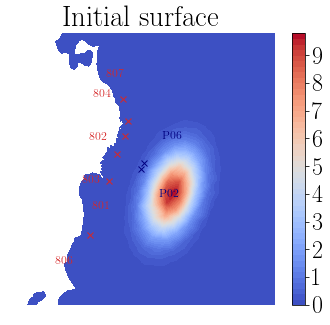

In [11]:
R = FunctionSpace(mesh, "R", 0)

q0 = Function(TaylorHood)
with stop_annotating():  # NOTE: VERY IMPORTANT!
    u0, eta0 = q0.split()
    loc = (0.7e+06, 4.2e+06)
    radii = (48e+03, 96e+03)
    angle = pi/12
    eta0.interpolate(10*gaussian([loc + radii, ], mesh, rotation=angle))
eta0.dat.name = "Initial surface"

axes = plot_field(eta0);
xg, yg = op.gauges["P02"]["coords"]
axes.set_xlim([xg - 0.3e+06, xg + 0.3e+06]);
axes.set_ylim([yg - 0.35e+06, yg + 0.35e+06]);
op.annotate_plot(axes)

q_init = Function(TaylorHood)
q_init.project(q0);

In [12]:
def solve_forward(init):
    q_.assign(init);
    
    for gauge in gauges:
        op.gauges[gauge]['timeseries'] = []
        op.gauges[gauge]['diff'] = []
        op.gauges[gauge]['timeseries_smooth'] = []
        op.gauges[gauge]['diff_smooth'] = []
        op.gauges[gauge]['init'] = None
        op.gauges[gauge]['data'] = []

    t = 0.0
    iteration = 0
    J = 0
    weight = Constant(1.0)
    eta_obs = Constant(0.0)
    while t < op.end_time:

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) or t >= op.end_time - 0.5*op.dt else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:

            # Point evaluation at gauges
            eta_discrete = eta.at(op.gauges[gauge]["coords"])
            if op.gauges[gauge]['init'] is None:
                op.gauges[gauge]['init'] = eta_discrete
            eta_discrete -= op.gauges[gauge]['init']
            op.gauges[gauge]['timeseries'].append(eta_discrete)
                
            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)
            op.gauges[gauge]['data'].append(obs)

            # Discrete form of error
            diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
            op.gauges[gauge]['diff'].append(diff)

            # Continuous form of error
            I = op.gauges[gauge]['indicator']
            diff = 0.5*I*(eta - eta_obs)**2
            J += assemble(weight*dtc*diff*dx)
            op.gauges[gauge]['diff_smooth'].append(assemble(diff*dx, annotate=False))
            op.gauges[gauge]['timeseries_smooth'].append(assemble(I*eta_obs*dx, annotate=False))

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    return J

# Gauge indicators

In [13]:
gauges = list(op.gauges.keys())
radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
P0 = FunctionSpace(mesh, "DG", 0)
for gauge in gauges:
    loc = op.gauges[gauge]["coords"]
    op.gauges[gauge]['indicator'] = interpolate(ellipse([loc + (radius,), ], mesh), P0)
    op.gauges[gauge]['indicator'].assign(op.gauges[gauge]['indicator']/assemble(op.gauges[gauge]['indicator']*dx))

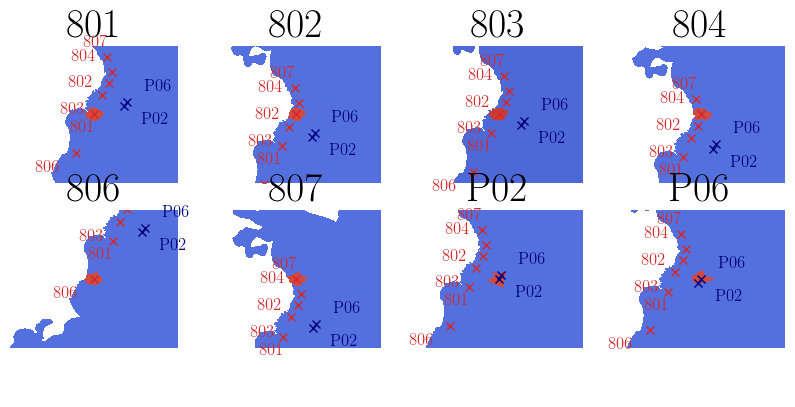

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(10, 4), dpi=100)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    tc = tricontourf(op.gauges[gauge]['indicator'], axes=ax, cmap='coolwarm')
    xg, yg = op.gauges[gauge]["coords"]
    ax.set_xlim([xg - 0.2e+06, xg + 0.2e+06]);
    ax.set_ylim([yg - 0.25e+06, yg + 0.25e+06]);
    ax.set_title(gauge)
    op.annotate_plot(ax, coords='utm')
    ax.axis(False)

In [15]:
times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for gauge in gauges:
    op.sample_timeseries(gauge, sample=op.gauges[gauge]['sample'], detide=True)

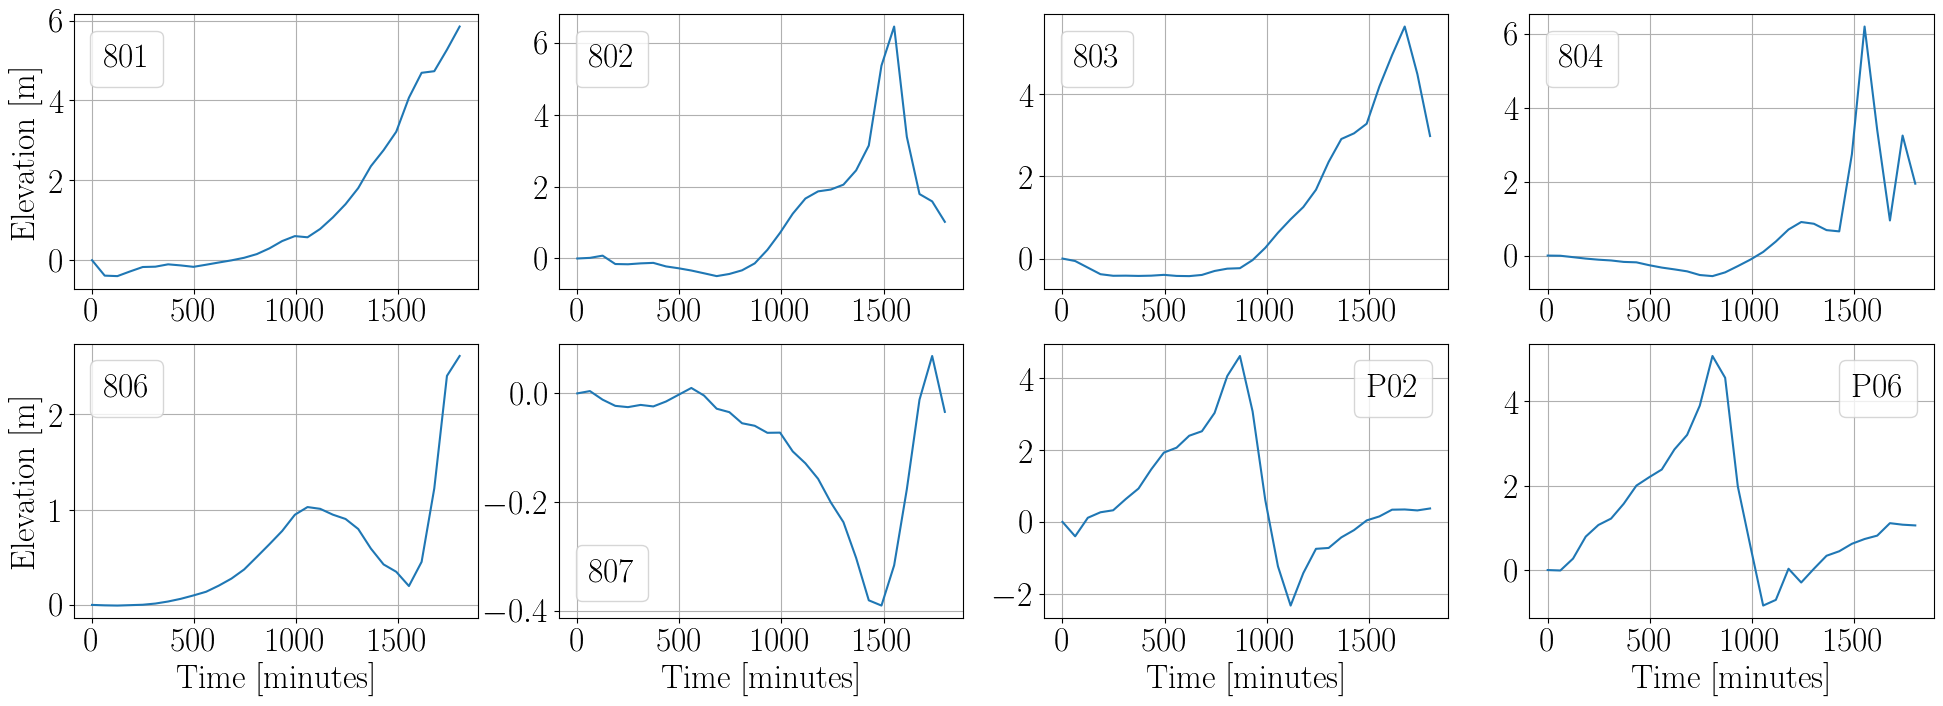

In [16]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)
t = np.linspace(0, op.end_time, 150)
for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times, op.gauges[gauge]['interpolator'](times), label=gauge)
    ax.legend(handlelength=0, handletextpad=0)
    ax.grid(True)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")

In [ ]:
J = solve_forward(q_init)
print("Quantity of interest = {:.4e}".format(J))

Having run the forward model, we can compare the initial and final solution, as well as the discrete and continuous versions of the timeseries.

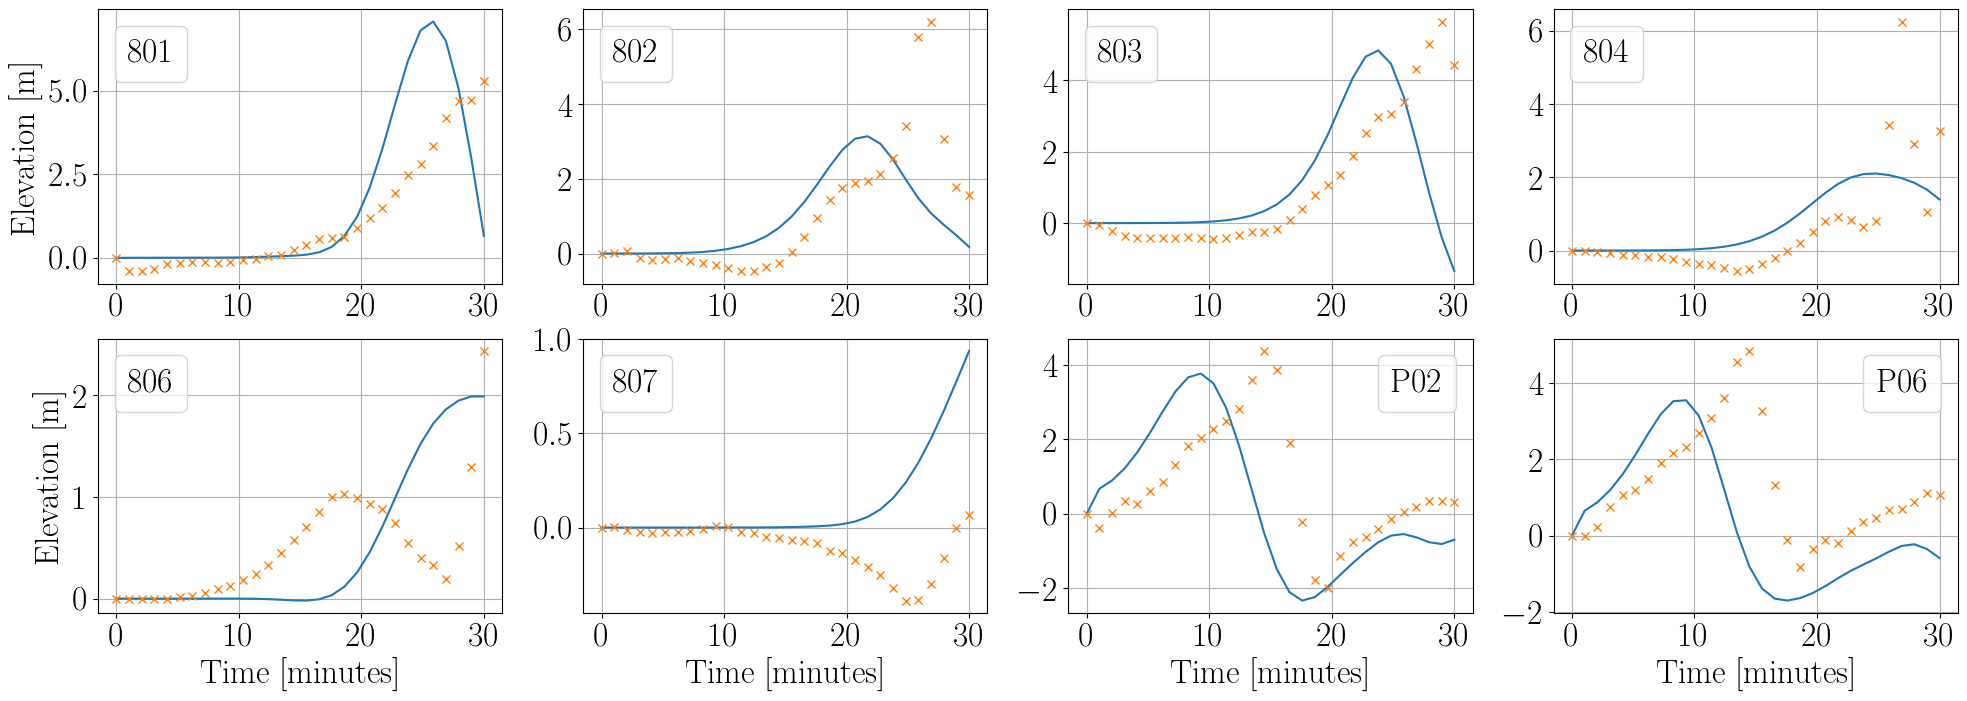

In [18]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 8), dpi=100)

for i, gauge in enumerate(gauges):
    ax = axes[i//4, i%4]
    ax.plot(times/60, op.gauges[gauge]['timeseries'], label=gauge)
    ax.plot(times/60, op.gauges[gauge]['data'], 'x')
    ax.legend(handlelength=0, handletextpad=0)
    if i >= 4:
        ax.set_xlabel("Time [minutes]")
    if i%4 == 0:
        ax.set_ylabel("Elevation [m]")
    ax.grid(True)

## Discrete adjoint

Note that we only Taylor test the elevation and effectively zero out the perturbation away from the source.

In [21]:
c = Control(q_init)

In [22]:
stop_annotating();

In [23]:
Jhat = ReducedFunctional(J, c)

In [24]:
np.random.seed(0)
m0 = Function(TaylorHood).assign(q_init)
dm0 = Function(TaylorHood)
dm0.dat.data[1][:] = np.random.rand(*dm0.dat.data[1].shape)*m0.dat.data[1]
minconv = taylor_test(Jhat, m0, dm0)
assert minconv > 1.90, minconv

Running Taylor test
Computed residuals: [0.5900318396539035, 0.14761343694659956, 0.03701781302277851, 0.009372789255113645]
Computed convergence rates: [1.9989687552260627, 1.9955324831422205, 1.9816693151237643]
